In [1]:
# unintended bias analysis

# 1) ROC-AUC
# 2) FPED, FNED
# Sub AUC
# BPSN, BNSP
# Weighted bias score
# Pos AEG, Neg AEGb

In [55]:
# imports from other files
from danlp.models.embeddings  import load_wv_with_gensim
from gensim.models import KeyedVectors
from IPython.display import Image
import json
from keras import layers
from keras.models import Sequential
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences, plot_model
import matplotlib.pyplot as plt
import nltk
import numpy as np
import os
import pandas as pd
import pickle
import random
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
import tensorflow as tf # tf backend
from typing import Dict
import utils

In [3]:
# specific imports
from sklearn.metrics import roc_auc_score, roc_curve

### Load data and models

In [4]:
# load preprocessed and oversampled data splits

if "dataset_splits.pkl" not in os.listdir('data'):
    raise Exception("Dataset splits not found. Please run main file to generate them.")

with open("data/dataset_splits.pkl", "rb") as f:
    data = pickle.load(f)
    
X_train = data["X training preprocessed and oversampled"]
y_train = data["y training preprocessed and oversampled"]
X_test = data["X test preprocessed"]
y_test = data["y test"]

print("Shapes:")
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

Shapes:
(3424,) (3424,)
(658,) (658,)


In [5]:
# load test set
with open("data/X_test_cnn.pkl", "rb") as f:
    X_test_padded = pickle.load(f)

In [6]:
# open cnn results (incl. proba and pred)
with open("models/cnn_results.pkl", "rb") as f:
    cnn_results = pickle.load(f)

#### Load and predict synthetic data

In [73]:
# load synthetic data
synth_data = pd.read_excel("g:/My Drive/ITC, 5th semester (Thesis)/Code/Github_code/create_synthetic_dataset/synthetic_data.xlsx")

# all data
X_synth = synth_data['text']
y_synth = synth_data['toxic']

print(len(X_synth), "sentences")
synth_data.head()

# load preprocessed, tokenized and padded version of X_synth
with open("data/X_synthetic_data_prepared.pkl", "rb") as f:
    X_synth_padded = pickle.load(f)

12780 sentences


In [74]:
# predict synthetic dataset using models
# store predictions in the dataframe

for i in range(1,11): # for each version of the model
    model_path = "models/initializations/cnn"+str(i)+".keras"
    model = tf.keras.models.load_model(model_path) # load model
    print(model_path)
    
    # predict synthetic dataset
    synth_data["proba"+str(i)] = model.predict(X_synth_padded)
    synth_data["pred"+str(i)] = synth_data["proba"+str(i)] > 0.5
    synth_data["pred"+str(i)] = synth_data["pred"+str(i)].astype(int)

models/initializations/cnn1.keras
400/400 [==============================] - 2s 5ms/step
models/initializations/cnn2.keras
400/400 [==============================] - 2s 6ms/step
models/initializations/cnn3.keras
400/400 [==============================] - 2s 6ms/step
models/initializations/cnn4.keras
400/400 [==============================] - 2s 6ms/step
models/initializations/cnn5.keras
400/400 [==============================] - 3s 8ms/step
models/initializations/cnn6.keras
400/400 [==============================] - 2s 6ms/step
models/initializations/cnn7.keras
400/400 [==============================] - 2s 6ms/step
models/initializations/cnn8.keras
400/400 [==============================] - 3s 7ms/step
models/initializations/cnn9.keras
400/400 [==============================] - 3s 7ms/step
models/initializations/cnn10.keras
400/400 [==============================] - 3s 7ms/step


In [77]:
synth_data.head()

,text,group,identity_term,toxic,proba1,pred1,proba2,pred2,proba3,pred3,...,proba6,pred6,proba7,pred7,proba8,pred8,proba9,pred9,proba10,pred10
0,kvinder er klamme og generelt bare nederen,F,kvinder,1,0.812915,1,0.456805,0,0.803909,1,...,0.735921,1,0.773988,1,0.527258,1,0.821311,1,0.715369,1
1,piger er klamme og generelt bare nederen,F,piger,1,0.913908,1,0.832007,1,0.934150,1,...,0.897367,1,0.942992,1,0.603125,1,0.924615,1,0.813730,1
2,damer er klamme og generelt bare nederen,F,damer,1,0.897616,1,0.569680,1,0.821499,1,...,0.768842,1,0.771995,1,0.461101,0,0.860523,1,0.464409,0
3,koner er klamme og generelt bare nederen,F,koner,1,0.917057,1,0.685621,1,0.915354,1,...,0.767486,1,0.925180,1,0.486145,0,0.924026,1,0.832951,1
4,kvindfolk er klamme og generelt bare nederen,F,kvindfolk,1,0.932321,1,0.843412,1,0.921474,1,...,0.884182,1,0.952794,1,0.688719,1,0.957226,1,0.809818,1


### 1) ROC-AUC

In [76]:
# ROC-AUC on test set 

aucs_test = [roc_auc_score(y_test, cnn_results[model]['proba']) for model in cnn_results.keys()]
print("Avg. AUC:", round(np.mean(aucs_test), 4))

Avg. AUC: 0.788


In [80]:
# ROC-AUC on synthetic data set 

aucs_synthetic = []
for i in range(1,11):
    proba = synth_data['proba'+str(i)]
    aucs_synthetic.append(roc_auc_score(y_synth, proba))

print("Avg. AUC:", round(np.mean(aucs_synthetic), 4))

Avg. AUC: 0.7127


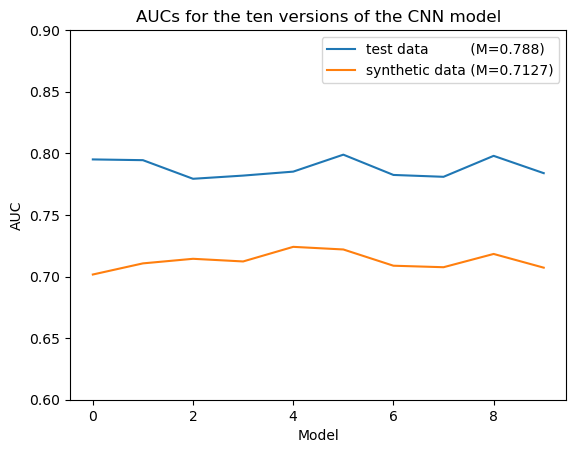

In [147]:
# plot aucs for both datasets
plt.plot(aucs_test, label=f"test data   (M={round(np.mean(aucs_test), 4)})")
plt.plot(aucs_synthetic, label=f"synthetic data (M={round(np.mean(aucs_synthetic), 4)})")
plt.ylim(.6, .9)
plt.title("AUCs for the ten versions of the CNN model")
plt.legend(loc="upper right")
plt.ylabel("AUC")
plt.xlabel("Model")
plt.show()

### 2) FPED, FNED

In [56]:
def compute_confusion_counts(y_actual:np.ndarray, y_pred:np.ndarray) -> Dict[str, int]:
    """Computes confusion counts, i.e. true positive, true negative, false positive, and false negative.

    Args:
        y_actual (np.ndarray): actual labels
        y_pred (np.ndarray): predicted labels

    Returns:
        Dict[str, int]: keys = metric name, values = counts
    """
    tp = sum([a==1 and p==1 for (a, p) in zip(y_actual, y_pred)])
    tn = sum([a==0 and p==0 for (a, p) in zip(y_actual, y_pred)])
    fp = sum([a==0 and p==1 for (a, p) in zip(y_actual, y_pred)])
    fn = sum([a==1 and p==0 for (a, p) in zip(y_actual, y_pred)])
    return {"tp":tp, "tn":tn, "fp":fp, "fn":fn}

In [82]:
# test this function using the latest model
print(compute_confusion_counts(y_synth, synth_data['pred10']))
print(confusion_matrix(y_synth, synth_data['pred10']))

{'tp': 795, 'tn': 6251, 'fp': 139, 'fn': 5595}
[[6251  139]
 [5595  795]]


In [83]:
# TODO check these calculatiosn and synonyms

def compute_confusion_rates(y_actual:np.ndarray, y_pred:np.ndarray) -> Dict[str, int]:
    """Compute the confusion rates, i.e. true positive rate, true negative rate, false positive rate, and false negative rate.

    Args:
        y_actual (np.ndarray): actual labels
        y_pred (np.ndarray): predicted labels

    Returns:
        Dict[str, int]: keys = metric name, values = rates
    """
    conf_counts = compute_confusion_counts(y_actual, y_pred)
    actually_pos = conf_counts['tp'] + conf_counts['fn']
    actually_neg = conf_counts['tn'] + conf_counts['fp']
    
    # true positive rate = sensitivity = recall
    tpr = conf_counts['tp'] / actually_pos

    # true negative rate = specificity
    tnr = conf_counts['tn'] / actually_neg
    
    # false positive rate = fall-out
    fpr = 1 - tnr
    
    # false negative rate = miss rate
    fnr = 1 - tpr
    
    return {
        "tpr": tpr,
        "tnr": tnr,
        "fpr": fpr,
        "fnr": fnr
    }

In [84]:
# test this function using the latest model
compute_confusion_rates(y_synth, synth_data['pred10'])

{'tpr': 0.12441314553990611,
 'tnr': 0.9782472613458529,
 'fpr': 0.021752738654147064,
 'fnr': 0.8755868544600939}

In [90]:
# calculate per-term fpr for the latest model

grouping = synth_data.groupby('identity_term')
fprs = dict()
for i in grouping:
    grouping_name = i[0]
    grouping_df = i[1]
    
    grouping_fprs = []
    for i in range(1,11):
        rates = compute_confusion_rates(grouping_df['toxic'], grouping_df['pred'+str(i)])
        grouping_fprs.append(rates['fpr'])
    fprs[grouping_name] = grouping_fprs

In [94]:
fprs

{'androgyn': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 'androgyne': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 'bedstefar': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 'bedstefædre': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 'bedstemor': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 'bedstemødre': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 'bror': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 'brødre': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 'dame': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 'damer': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 'datter': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 'dreng': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 'drenge': [0.0,
  0.3222222222222222,
  0.3222222222222222,
  0.4444444444444444,
  0.0,
  0.0,
  0.3222222222222222,
  0.0,
  0.0,
  0.0],
 'døtre': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 'en androgyn': [0.0, 0.0,

In [122]:
# calculate per-term fprs and fnrs 

grouping = synth_data.groupby('identity_term')
per_term_fprs = dict()
background_fprs = dict()
per_term_fnrs = dict()
background_fnrs = dict()

for i in range(1,11): # for each model variant

    grouping_fprs = dict()
    grouping_fnrs = dict()
    for g in grouping: # for each term
        grouping_name = g[0]
        grouping_df = g[1]
        rates = compute_confusion_rates(grouping_df['toxic'], grouping_df['pred'+str(i)])
        grouping_fprs[grouping_name] = rates['fpr']
        grouping_fnrs[grouping_name] = rates['fnr']

    per_term_fprs[str(i)] = grouping_fprs
    per_term_fnrs[str(i)] = grouping_fnrs
    
    background_rates = compute_confusion_rates(synth_data['toxic'], synth_data['pred'+str(i)])
    background_fprs[str(i)] = background_rates['fpr']
    background_fnrs[str(i)] = background_rates['fnr']

In [123]:
per_term_fprs

{'1': {'androgyn': 0.0,
  'androgyne': 0.0,
  'bedstefar': 0.0,
  'bedstefædre': 0.0,
  'bedstemor': 0.0,
  'bedstemødre': 0.0,
  'bror': 0.0,
  'brødre': 0.0,
  'dame': 0.0,
  'damer': 0.0,
  'datter': 0.0,
  'dreng': 0.0,
  'drenge': 0.0,
  'døtre': 0.0,
  'en androgyn': 0.0,
  'en bedstefar': 0.0,
  'en bedstemor': 0.0,
  'en bror': 0.0,
  'en dame': 0.0,
  'en datter': 0.0,
  'en dreng ': 0.0,
  'en far': 0.0,
  'en fyr': 0.37037037037037035,
  'en fætter': 0.0,
  'en genderqueer person': 0.0,
  'en han': 0.0,
  'en hermafrodit': 0.0,
  'en herre': 0.0,
  'en hun': 0.0,
  'en husbond': 0.0,
  'en hustru': 0.0,
  'en ikkebinær person': 0.0,
  'en interkønnet person': 0.0,
  'en intetkønnet person': 0.0,
  'en kone': 0.0,
  'en kusine': 0.0,
  'en kvinde': 0.0,
  'en lgbt person': 0.0,
  'en mand': 0.0,
  'en mor': 0.0,
  'en nonbinær person': 0.0,
  'en pige': 0.0,
  'en queer person': 0.0,
  'en svigerdatter': 0.0,
  'en svigerinde': 0.0,
  'en svigersøn': 0.0,
  'en svoger': 0.0,


In [124]:
background_fprs

{'1': 0.013928012519561772,
 '2': 0.025978090766823114,
 '3': 0.015649452269170583,
 '4': 0.028951486697965545,
 '5': 0.011111111111111072,
 '6': 0.010954616588419452,
 '7': 0.015649452269170583,
 '8': 0.010954616588419452,
 '9': 0.010954616588419452,
 '10': 0.021752738654147064}

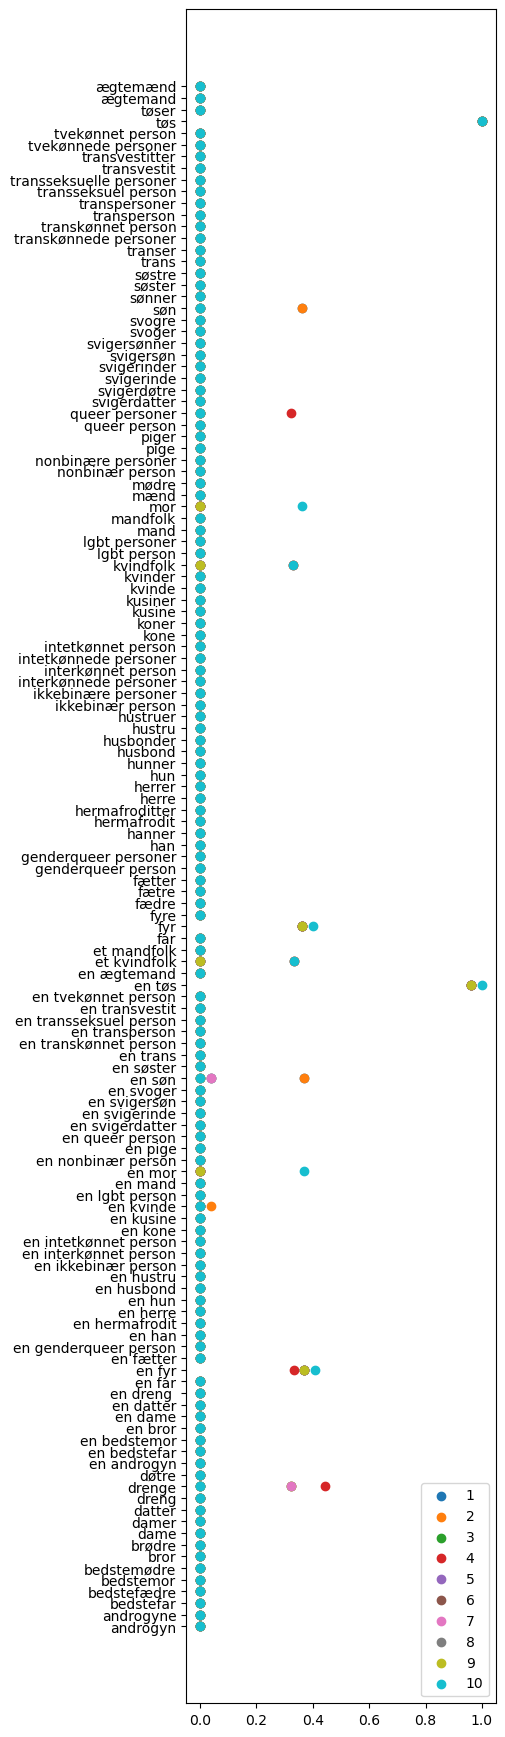

In [128]:
# plot fprs per term

plt.figure(figsize=(4,22))
for i in range(1, 11):
    y = per_term_fprs[str(i)].keys()
    x = per_term_fprs[str(i)].values()
    plt.scatter(x, y, label=i)
plt.legend()
plt.show()

In [126]:
def compute_fped(background_fpr:float, per_term_fprs:Dict[str, float]):
    fped = sum(
        abs(background_fpr - fpr_t)
        for fpr_t in per_term_fprs.values()
    )
    return fped

In [127]:
fpeds = [compute_fped(background_fprs[str(i)], per_term_fprs[str(i)]) for i in range(1,11)]

print("Mean FPED:", np.mean(fpeds))

Mean FPED: 5.2889290784967375


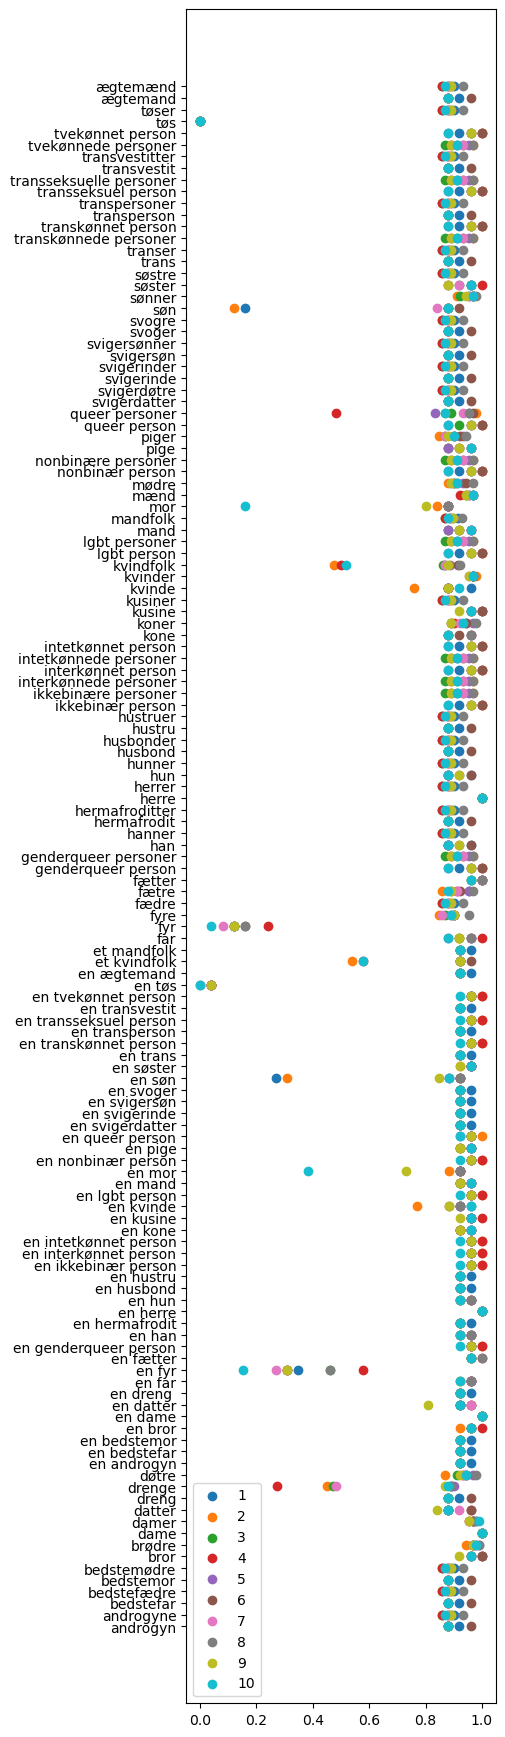

In [129]:
# plot fnrs per term

plt.figure(figsize=(4,22))
for i in range(1, 11):
    y = per_term_fnrs[str(i)].keys()
    x = per_term_fnrs[str(i)].values()
    plt.scatter(x, y, label=i)
plt.legend()
plt.show()

In [130]:
def compute_fned(background_fnr:float, per_term_fnrs:Dict[str, float]):
    fned = sum(
        abs(background_fnr - fnr_t)
        for fnr_t in per_term_fnrs.values()
    )
    return fned

In [132]:
fneds = [compute_fned(background_fnrs[str(i)], per_term_fnrs[str(i)]) for i in range(1,11)]

print("Mean FNED:", np.mean(fneds))

Mean FNED: 8.822660245587883


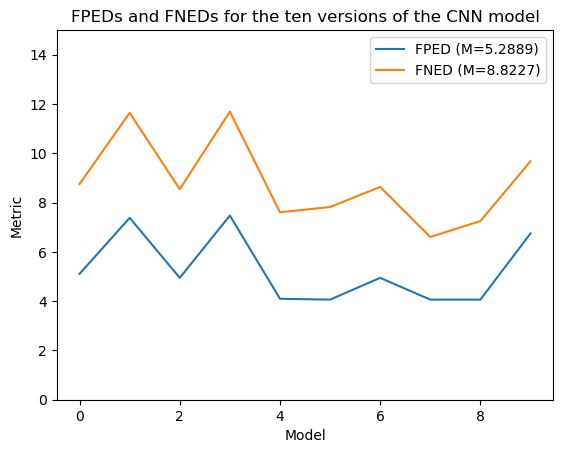

In [146]:
# plot fped and fneds
plt.plot(fpeds, label=f"FPED (M={round(np.mean(fpeds),4)})")
plt.plot(fneds, label=f"FNED (M={round(np.mean(fneds),4)})")
plt.ylim(0, 15)
plt.title("FPEDs and FNEDs for the ten versions of the CNN model")
plt.legend(loc="upper right")
plt.ylabel("Metric")
plt.xlabel("Model")
plt.show()